# Riiid Kaggle Competition Baseline

> This is a time-series data competition that uses past student behavior to predict whether or not they get questions in the future correct. The link: https://www.kaggle.com/c/riiid-test-answer-prediction/overview

> By Arda Sozer and Joshua Chung


In [ ]:
#Some standard package imports, will import Keras frontend and Tensorflow backend as well.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import datetime
import seaborn as sns
from google.colab import drive
from sklearn import preprocessing
py.offline.init_notebook_mode(connected=True)
from collections import Counter

# Data Loading

In [ ]:
#By setting data types when reading in the csv we save a significant amount of memory.
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# IMPORTANT! Only run this cell once, after the users have been selected from this larger dataset
# the smaller dataset will be saved to make this query much faster in the future.
data= pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/train.csv', dtype=dtypes)
data

,Unnamed: 0,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,21228163,21228163,0,455973631,7900,False,0,2,0,NaN,<NA>
1,21228164,21228164,21487,455973631,7876,False,1,3,1,25000.0,False
2,21228165,21228165,44108,455973631,175,False,2,3,0,18000.0,False
3,21228166,21228166,61342,455973631,1278,False,3,3,1,19000.0,False
4,21228167,21228167,106235,455973631,2065,False,4,2,1,14000.0,False
...,...,...,...,...,...,...,...,...,...,...,...
68466,86591936,86591936,13809512777,1842816145,3309,False,9998,0,1,17000.0,True
68467,86591937,86591937,13809512777,1842816145,3311,False,9998,3,1,17000.0,True
68468,86591938,86591938,13809629680,1842816145,2649,False,9999,1,1,7333.0,True
68469,86591939,86591939,13809629680,1842816145,2647,False,9999,2,1,7333.0,True


In [ ]:
# IMPORTANT! Only run this cell once, after the users have been selected from this larger dataset
# the smaller dataset will be saved to make this query much faster in the future.
# This cell specifically selects for the top 4 users in terms of number of rows for our training data
# Also selects the 5th highest user for a holdout dataset to see if learning on the other users can 
# work for an unseen user.

user_id = data.user_id
uid = user_id.value_counts().index[:5]
print(uid)
uid1 = uid[:4]

uid2 = uid[4]
train = data.loc[data.user_id.isin(uid1),:]

holdout = data.loc[data.user_id == uid2,:]
holdout
train
holdout.to_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/holdout.csv')
train.to_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/train.csv')
#We see that we have limited the data to the single user with user_id = 801103753. This is the user with the greatest amount of data, so we pick them to train our models.
#We also have a different user as a holdout dataset to see if the model can generalize to other users.

NameError: ignored

In [ ]:
# This cell is what should be run after the first time this notebook is run. This way the notebook only
# needs to read a limited amount of data, saving memory and time

holdout = pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/holdout.csv',index_col='row_id', dtype = dtypes).drop('Unnamed: 0',axis = 1)
train =pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/train.csv', index_col='row_id', dtype = dtypes).drop('Unnamed: 0',axis = 1)
train['row_id'] = train.index
holdout['row_id'] = holdout.index

In [ ]:
#load the lectures data
lectures = pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/lectures.csv')

In [ ]:
#load the questions data
questions= pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/questions.csv')
(questions.tags)

0         51 131 162 38
1             131 36 81
2        131 101 162 92
3        131 149 162 29
4          131 5 162 38
              ...      
13518                14
13519                 8
13520                73
13521               125
13522                55
Name: tags, Length: 13523, dtype: object

# Feature Engineering


In [ ]:

def str_to_list(string):
  #This function takes in the list-like strings that contain tags of each question and splits them into an actual list of tags
  if type(string) == float:
    ls = np.array(string)
    ls = [188]
    return ls
  ls = [int(x) for x in (string.split(' '))]
  ls= np.array(ls)
  ls = ls[~np.isnan(ls)]
  return ls



In [ ]:
#This cell one-hot encodes the tags so that each tag is an indicator variable for the specific question
j = 0
z = np.zeros((13523,189))
for i in questions.tags.apply(str_to_list).to_numpy():
  # print(i)
  # print(j)
  z[j][i] = 1
  j+=1
tags = pd.DataFrame(data = z,columns=np.unique(np.concatenate(questions.tags.apply(str_to_list).to_numpy())))
question_tags = pd.concat((questions['question_id'],tags), axis = 1)
question_tags.rename(columns={'question_id':'content_id'}, inplace = True)
question_tags

,content_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13518,13518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13519,13519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13520,13520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13521,13521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# This cell takes the rows that indicate a lecture was watched, and creates a new column that is 1
# if a lecture of the same topic was viewed before answering the question and 0 otherwise. (Training/Dev/Test Data)
lecture_watched = train[train['content_type_id']==True][['user_id','content_id','timestamp']]
only_questions = train[train['content_type_id']==False]#.set_index('row_id',drop = False)

m = only_questions.merge(lecture_watched, on =['user_id','content_id'], how='inner')
m['time'] = m.timestamp_y<m.timestamp_x

lecture_idx = m[m.time == True].row_id
z = np.zeros(only_questions.shape[0])

only_questions = only_questions.set_index('row_id')
only_questions['watched_lecture'] = np.zeros(only_questions.shape[0])
only_questions.loc[lecture_idx,'watched_lecture'] = 1

only_questions.loc[only_questions['prior_question_elapsed_time'].isnull(),'prior_question_elapsed_time'] =0
only_questions.loc[only_questions['prior_question_had_explanation'].isnull(),'prior_question_had_explanation']=False
only_questions['prior_question_had_explanation'] = only_questions['prior_question_had_explanation'].astype(int)
only_questions

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,watched_lecture
row_id,,,,,,,,,,
21228163,0,455973631,7900,False,0,2,0,0.0,0,0.0
21228164,21487,455973631,7876,False,1,3,1,25000.0,0,0.0
21228165,44108,455973631,175,False,2,3,0,18000.0,0,0.0
21228166,61342,455973631,1278,False,3,3,1,19000.0,0,0.0
21228167,106235,455973631,2065,False,4,2,1,14000.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
86591936,13809512777,1842816145,3309,False,9998,0,1,17000.0,1,0.0
86591937,13809512777,1842816145,3311,False,9998,3,1,17000.0,1,0.0
86591938,13809629680,1842816145,2649,False,9999,1,1,7333.0,1,0.0


In [ ]:
#This cell merges the question tags with the training data so each row will have the related tags as indicator variables
train_cleaned  = only_questions.merge(question_tags,on='content_id', how='inner')
X = train_cleaned.drop(['user_answer','answered_correctly','task_container_id','content_type_id','content_id','user_id','timestamp','task_container_id'], axis = 1)
Y = train_cleaned['answered_correctly']
column_names = X.columns
column_names

Index([   'prior_question_elapsed_time', 'prior_question_had_explanation',
                      'watched_lecture',                                0,
                                      1,                                2,
                                      3,                                4,
                                      5,                                6,
       ...
                                    179,                              180,
                                    181,                              182,
                                    183,                              184,
                                    185,                              186,
                                    187,                              188],
      dtype='object', length=192)

In [ ]:
#Shuffles and splits the data into training, validation, and testing datasets
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X =X.to_numpy()[idx]
Y=Y.to_numpy()[idx]
train_x = X[:round(len(X)*.7),:]
train_y = Y[:round(len(X)*.7)]
val_x = X[round(len(X)*.7):round(len(X)*.9),:]
val_y = Y[round(len(X)*.7):round(len(X)*.9)]
test_x  = X[round(len(X)*.9):,:]
test_y = Y[round(len(X)*.9):]
train_x.shape


(47337, 192)

In [ ]:
# This cell takes the rows that indicate a lecture was watched, and creates a new column that is 1 if a lecture 
# of the same topic was viewed before answering the question and 0 otherwise. (Holdout Data)
lecture_watched_holdout = holdout[holdout['content_type_id']==True][['user_id','content_id','timestamp']]
only_questions_holdout = holdout[holdout['content_type_id']==False]#.set_index('row_id',drop = False)

m = only_questions_holdout.merge(lecture_watched_holdout, on =['user_id','content_id'], how='inner')
m['time'] = m.timestamp_y<m.timestamp_x
print(m)
lecture_idx = m[m.time == True].row_id
z = np.zeros(only_questions_holdout.shape[0])

only_questions_holdout = only_questions_holdout.set_index('row_id')
only_questions_holdout['watched_lecture'] = np.zeros(only_questions_holdout.shape[0])
only_questions_holdout.loc[lecture_idx,'watched_lecture'] = 1

only_questions_holdout.loc[only_questions_holdout['prior_question_elapsed_time'].isnull(),'prior_question_elapsed_time'] =0
only_questions_holdout.loc[only_questions_holdout['prior_question_had_explanation'].isnull(),'prior_question_had_explanation']=False
only_questions_holdout['prior_question_had_explanation'] = only_questions_holdout['prior_question_had_explanation'].astype(int)
only_questions_holdout

     timestamp_x     user_id  content_id  ...    row_id  timestamp_y   time
0        3088007  1660941992          89  ...  77986894   6221956945  False
1        4666754  1660941992        3780  ...  77986918  27623787239  False
2      139467720  1660941992        3780  ...  77987010  27623787239  False
3      239013676  1660941992        3780  ...  77987188  27623787239  False
4       44792556  1660941992       10688  ...  77986944  24872514460  False
..           ...         ...         ...  ...       ...          ...    ...
177  30470273406  1660941992        9856  ...  78002995  25489652163   True
178  30850453177  1660941992        9835  ...  78003259   1001464033   True
179  31073403520  1660941992       11230  ...  78003408  29618460190   True
180  31182593750  1660941992        8317  ...  78003469   3429924775   True
181  31451784167  1660941992        9896  ...  78003594   1365609109   True

[182 rows x 12 columns]


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,watched_lecture
row_id,,,,,,,,,,
77986854,0,1660941992,7900,False,0,0,1,0.0,0,0.0
77986855,26297,1660941992,7876,False,1,2,0,23000.0,0,0.0
77986856,58056,1660941992,175,False,2,3,0,23000.0,0,0.0
77986857,84912,1660941992,1278,False,3,1,0,29000.0,0,0.0
77986858,191664,1660941992,2063,False,4,1,0,25000.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
78003624,31462348875,1660941992,7442,False,9996,0,0,84750.0,1,0.0
78003625,31465183846,1660941992,7206,False,9997,1,0,300000.0,1,0.0
78003626,31465183846,1660941992,7207,False,9997,0,0,300000.0,1,0.0


In [ ]:
#This cell merges the question tags with the training data so each row will have the related tags as indicator variables
holdout_cleaned  = only_questions_holdout.merge(question_tags,on='content_id', how='inner')
X_holdout = holdout_cleaned.drop(['user_answer','answered_correctly','task_container_id','content_type_id','content_id','user_id','timestamp','task_container_id'], axis = 1)
Y_holdout = holdout_cleaned['answered_correctly']


## EDA

Let us see what the dataset looks like below:

Let us find the number of observations and the number of features.

Below we see the columns and their types of the training set.

In [ ]:
train_x.shape

(47337, 192)

We see that there are 47337 observations and 192 features for the users with user_id in [801103753, 1478712595, 1842816145, 455973631].

Since we are interested in modelling student knowledge over time, let us carry out exploratory data analysis to see the details of the dataset.

We want to present the distribution of average correct answers of each student:

In [ ]:
# answers = train[train['answered_correctly']!=-1]

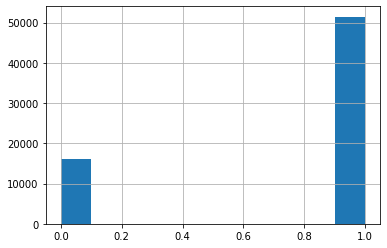

In [ ]:
correct = train[train["answered_correctly"] >= 0]
correct = correct["answered_correctly"]
correct.hist()

In [ ]:
correct.mean()

0.7610315864190228

We see the distribution of average correct(1) and incorrect(0) answers by the student. The student had a performance of approximately 76% correct answers.

In [ ]:
# questions_only = train[train['content_type_id']==False]#.set_index('row_id',drop = False)
explanation = only_questions.groupby(['prior_question_had_explanation', "answered_correctly"]).size()
explanation


prior_question_had_explanation  answered_correctly
0                               0                       20
                                1                       13
1                               0                     6971
                                1                     9405
dtype: int64

^  TAKEAWAY:
   Amongst the questions that had an explanation presented to them after they answered the previous question, the number of correct answers are 9405, and the count of incorrect answers was 6971. This is a correct answer percentage of approximately 72%.

   Amongst the questions that didn't have an explanation presented to them after they answered the previous question, the number of correct answers are 58, and the count of incorrect answers was 25. This is a correct answer percentage of approximately 70.0%.

   Although, the difference in total sample size between the two cases is sustanial, perhaps there is also not a substantial effect of the explanations after questions. After all the difference in performance is approximately 2%.

In [ ]:
lecture = only_questions.groupby(['watched_lecture', "answered_correctly"]).size()
lecture

watched_lecture  answered_correctly
0.0              0                     16095
                 1                     51265
1.0              0                        65
                 1                       199
dtype: int64

^  TAKEAWAY: 
  Amongst the questions that had lectures presented to them about the same topic before the question was asked, the number of correct answers are 199, and the count of incorrect answers was 65. This is a correct answer percentage of approximately 75.37%.

Amongst the questions that didn't have lectures presented to them about the same topic before the question was asked, the number of correct answers are 16095, and the count of incorrect answers was 51265. This is a correct answer percentage of approximately 76.11%.

Although, the difference in total sample size between the two cases is substanial, perhaps there is also not a substantial effect of the lectures. After all the difference in performance is less than 1%.

In [ ]:
correct = only_questions[only_questions["answered_correctly"] == 1]
incorrect = only_questions[only_questions["answered_correctly"] == 0]

correct_elapsed = correct["prior_question_elapsed_time"]
incorrect_elapsed = incorrect["prior_question_elapsed_time"]

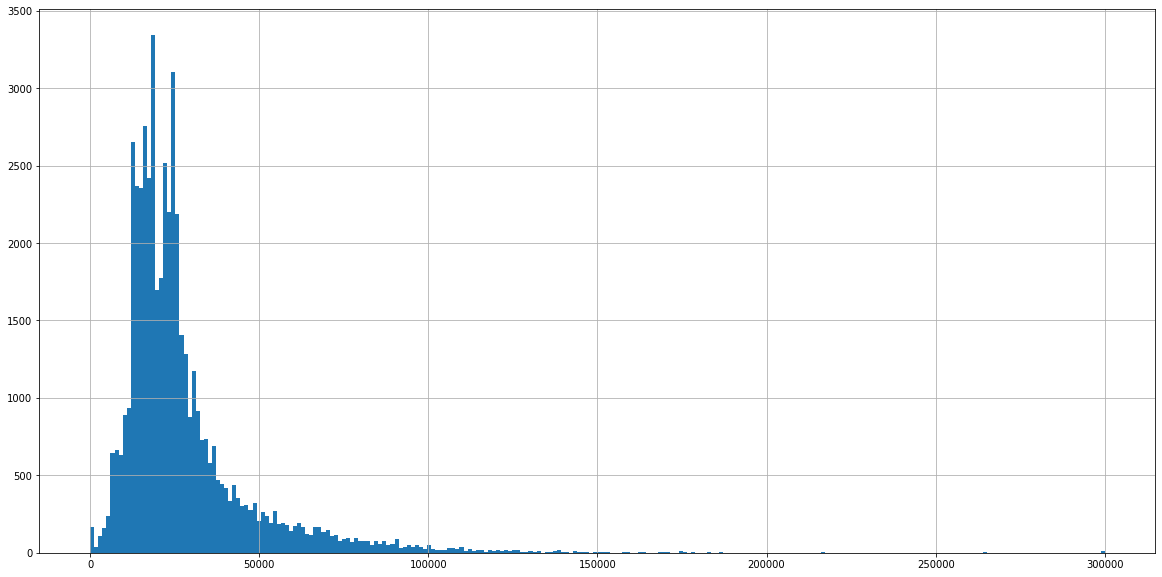

In [ ]:
#Histogram of elapsed times since last question for correctly answered questions
correct_elapsed.hist(bins = 250, figsize=(20,10))

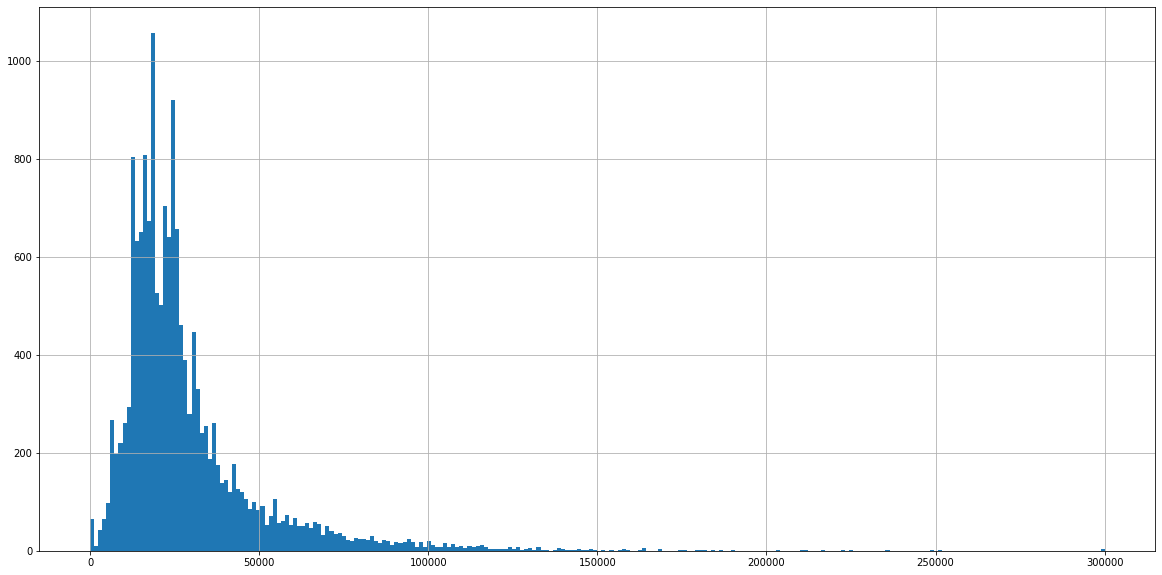

In [ ]:
#Histogram of elapsed times since last question for incorrectly answered questions
incorrect_elapsed.hist(bins = 250, figsize=(20,10))

We see that there are small differences in the distributions of elapsed times since the previous question for correctly and incorrectly answered questions. 

It seems as though correctly answered questiones are more commonly quickly answered since the last question, as compared to incorrectly answered questions. 

This might mean that the participants are using their own knowledge to quickly answer the questions that they know off by heart. In other words, if they know the answer to be correct they answer quickly, but if they don't, then they think about it for a little bit longer and then answer incorrectly.

Now, let us do analysis on the question tags in the dataset.

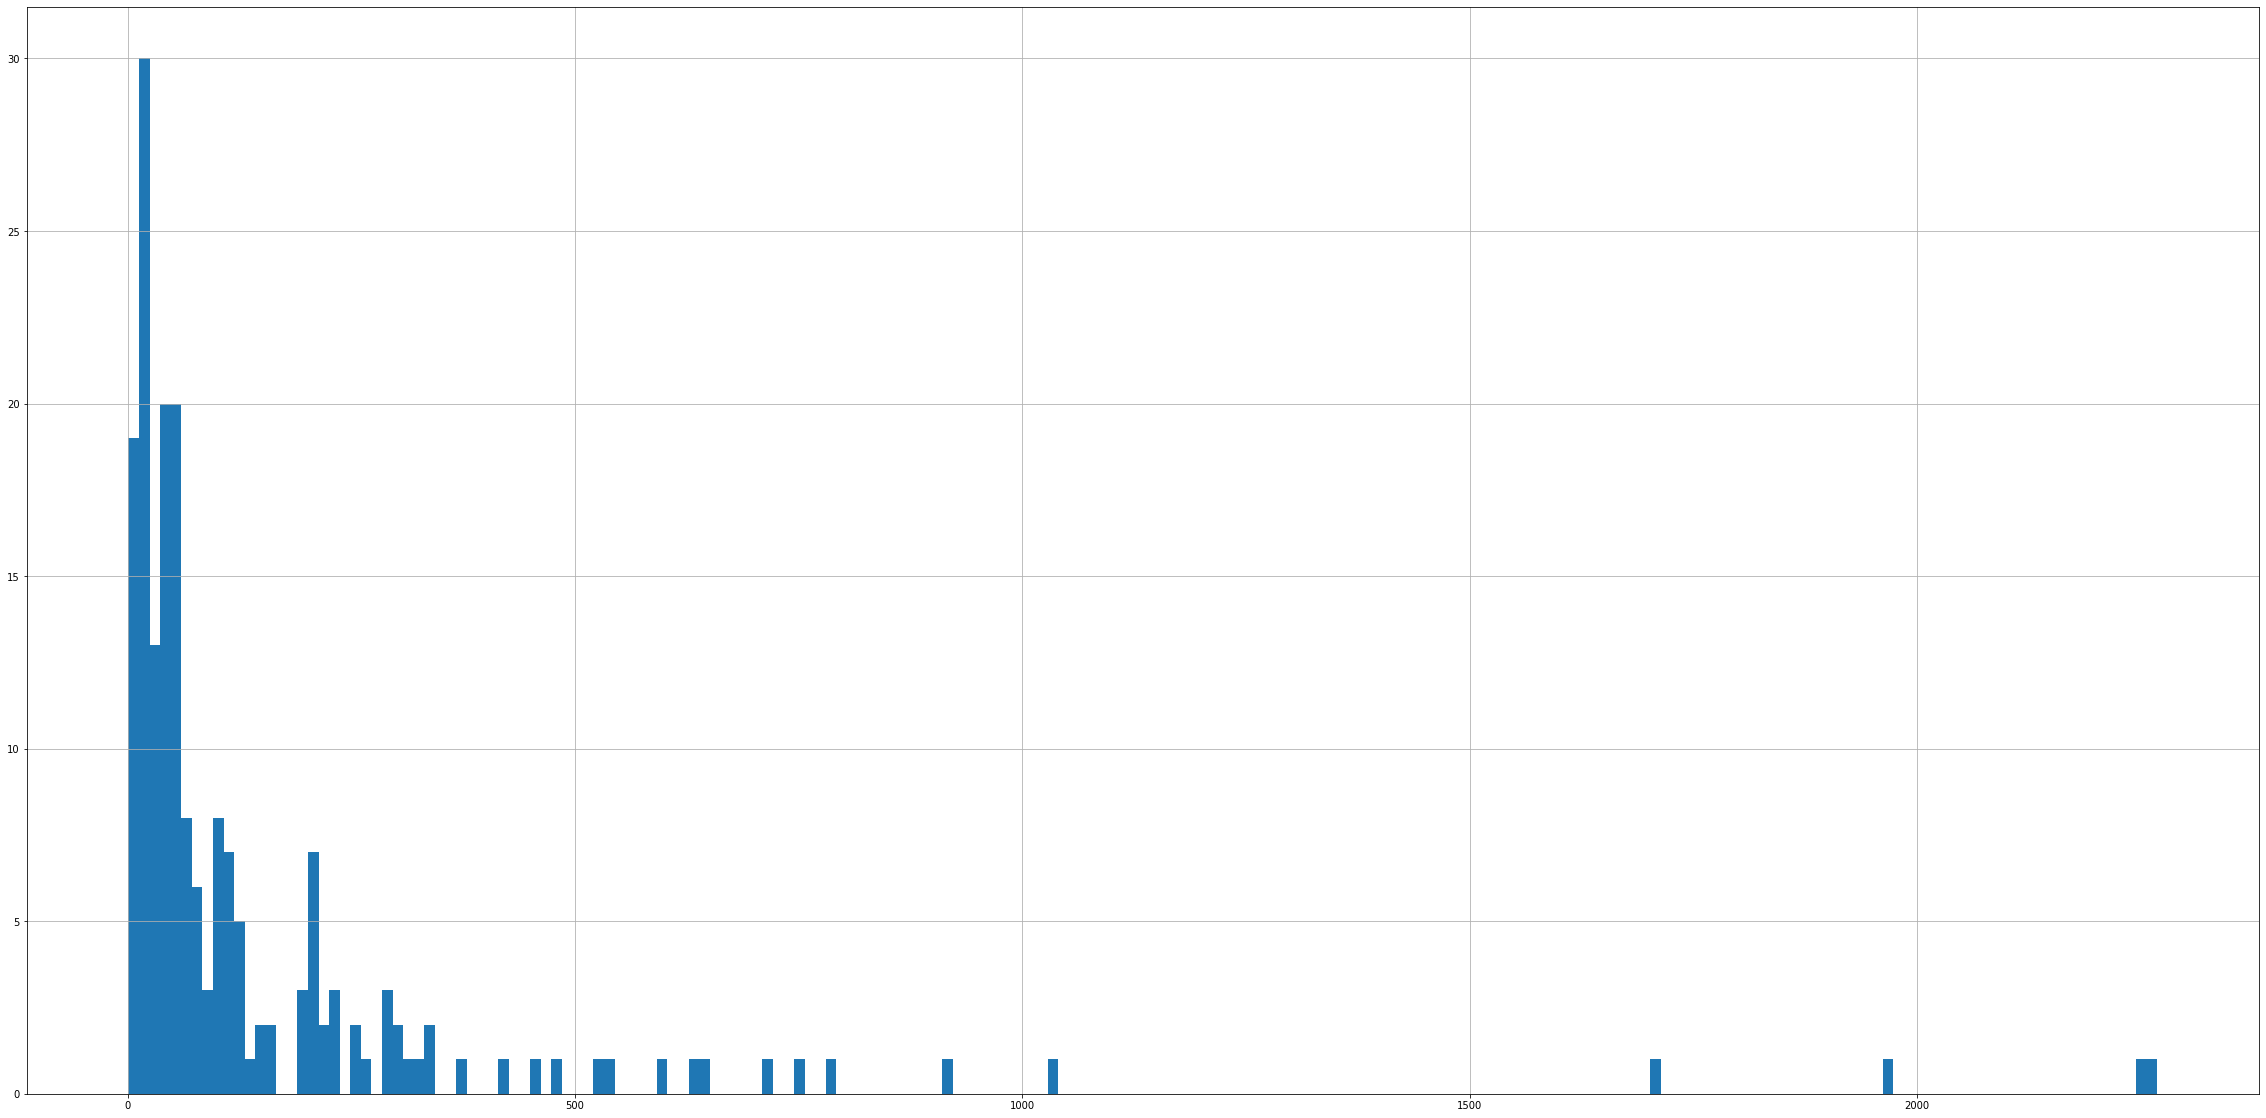

In [ ]:
tags = question_tags.drop('content_id',axis = 1).sum(axis = 0)
tags.hist(bins = 192, figsize=(40,20))

We see here that certain tags have extremely high frequency in the questions, however many tags are never seen or are only seen once, indicating an extremely sparse dataset.

## Model Baseline


> We will use a Logistic Regression for the baseline



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


In [ ]:
lg = LogisticRegression('elasticnet',solver ='saga', l1_ratio=.5, n_jobs=-1, max_iter=100, verbose = 2)
lg.fit(train_x,train_y)
print('fitted')
pred = lg.predict(val_x)
score = roc_auc_score(val_y, pred)
acc = accuracy_score(val_y, pred)
print(score, acc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 16 seconds
fitted
0.5 0.7608872458410351


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.8s finished


As we can see, the dev set auc_roc is at .5, meaning that our baseline model is effectively guessing the same value for every dev datapoint. Clearly there is room for improvement beyond this.

## Dimensionality Reduction Using PCA

In [ ]:
from sklearn.decomposition import PCA


Fraction of total variance in training data that is explained by first 1 components is: 
[0.99999999]
-----------------------------------------------

Fraction of total variance in training data that is explained by first 2 components is: 
[9.99999994e-01 4.82036788e-10]
-----------------------------------------------

Fraction of total variance in training data that is explained by first 3 components is: 
[9.99999994e-01 4.82036789e-10 4.49346871e-10]
-----------------------------------------------

Fraction of total variance in training data that is explained by first 4 components is: 
[9.99999994e-01 4.82036789e-10 4.49346871e-10 3.79391333e-10]
-----------------------------------------------

Fraction of total variance in training data that is explained by first 5 components is: 
[9.99999994e-01 4.82036789e-10 4.49346871e-10 3.79391337e-10
 2.85457648e-10]
-----------------------------------------------

Fraction of total variance in training data that is explained by first 10 comp

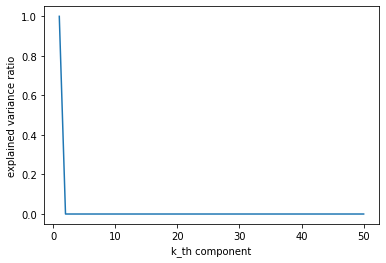

<Figure size 360x360 with 0 Axes>

In [ ]:
k_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]

# Iterating through component sizes.

for k in k_list:
    # Fitting the training data.
    pca = PCA(n_components=k)
    pca.fit_transform(train_x)
    print("Fraction of total variance in training data that is explained by first " + str(k) + 
          " components is: ")
    print(str(pca.explained_variance_ratio_))
    print("-----------------------------------------------")
    print()
    
# Plotting the fraction of the total variance in the training data is explained by the first 50 principal components.

y = pca.explained_variance_ratio_
x = np.arange(1, 51)
plt.plot(x, y)
plt.xlabel("k_th component")
plt.ylabel("explained variance ratio")
plt.figure(figsize=(5,5)); 
plt.show()

As we can see here, there is almost 0 variance explained by any number of components greater than 1.

## Visualisation with PCA

Text(0, 0.5, 'second dimension')

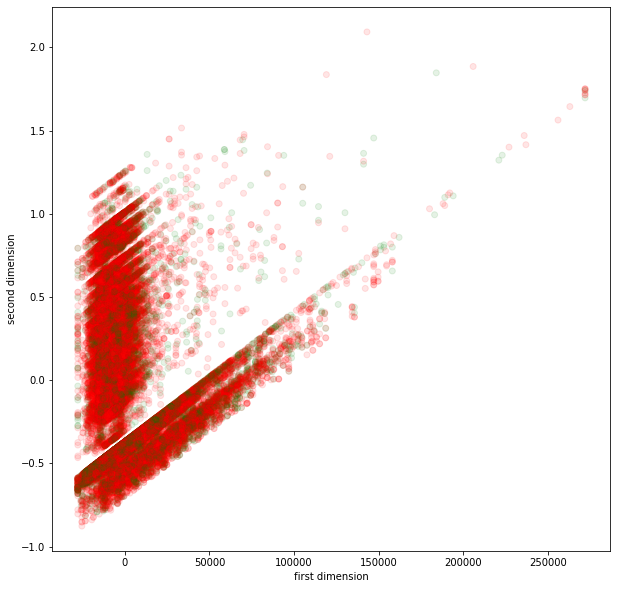

In [ ]:
    pca = PCA(n_components=2)
    y_pred = pca.fit_transform(train_x)
    x = y_pred[:,0] 
    y = y_pred[:,1]
    
    colors = []
    for label in train_y:
        if (label == 0):
            colors.append("g")
        else:
            colors.append("r")
            
    # Showing result as a square scatterplot, where red is poisonous and green is not poisonous
    plt.figure(figsize=(10,10)); 
    plt.scatter(x, y, c = colors, alpha = .1)
    plt.xlabel("first dimension")
    plt.ylabel("second dimension")

We do not see compelling evidence for clusters within the data, at least when using 2 PCA components.

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
# This cell iterates through a limited number of hyperparameters to get a quick look of which model we should choose
# moving forward.

cs = np.linspace(start = 0.001, stop = 10, num = 20)
best_score = -1
best_c = -1
for c in cs:
    lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto").fit(train_x, train_y)
    pred = lr.predict(val_x)
    score = roc_auc_score(val_y, pred)
    if (score > best_score):
        best_score = score
        best_c = c
    print("Score for Logistic Regression model with alpha = " + str(c) + " is: " + str(score))
    print("The weights for each topic are: ", lr.coef_)
    print("-------------------------------------------")
print("We found the alpha value that maximizes roc_auc score to be alpha = " + str(best_c) + " with score = " + str(best_score))


Score for Logistic Regression model with alpha = 0.001 is: 0.5
The weights for each topic are:  [[ 3.11528346e-05  1.51198502e-05  6.54014072e-08 -5.05863354e-08
  -1.05569013e-07  3.97215919e-07 -2.29223715e-09 -1.26195089e-08
   2.35984304e-07 -1.20878995e-09  1.53333840e-08  8.37868420e-08
   1.86982244e-07  4.72822601e-07 -3.35042046e-08  4.26557910e-07
   4.12096558e-08  8.63997934e-08 -2.08487425e-08 -8.88450792e-08
   1.51591213e-07  1.25664771e-08 -1.11754813e-07  2.74365431e-07
  -1.93222933e-08 -2.30444575e-08  1.94414648e-08 -8.38082022e-08
   1.92976936e-08 -3.28875080e-08  4.19547768e-07 -2.89364201e-08
   4.89711311e-06  3.57677319e-07 -1.01976788e-08  2.10288160e-07
   5.54623413e-09 -1.62863867e-09 -2.78486303e-07  9.65691939e-08
   7.62594747e-08  7.09170900e-06 -2.28151411e-07  7.67410773e-08
   3.49806859e-07 -2.45209978e-07 -1.13246657e-08 -1.86800298e-08
   3.69781137e-08 -9.27831821e-08 -2.93834308e-08 -6.40710589e-08
   5.46450088e-09 -6.12345828e-09  1.37582885e

## KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# This cell iterates through a limited number of hyperparameters to get a quick look of which model we should choose
# moving forward.
best_score = -1
best_n = 0
best_m = 0
metrics = ['sokalsneath']
for i in range(1, 10):
  for m in metrics:
    knn = KNeighborsClassifier(n_neighbors=i,metric=m, n_jobs=-1)
    knn.fit(train_x, train_y)
    pred = knn.predict(val_x)
    score = roc_auc_score(val_y, pred)
    if (score > best_score):
        best_score = score
        best_n = i
        best_m = m
    print("Score for KNN model with k = " + str(i) + "metric: "+m + " is: " + str(score))
print("------------------------------------------")
print("We found the 'n' value that maximizes roc_auc score to be n = " + str(best_n) +"metric: "+m+ " with score = " + str(best_score))


Score for KNN model with k = 1metric: sokalsneath is: 0.5140041695018486
Score for KNN model with k = 2metric: sokalsneath is: 0.5356724820400964
Score for KNN model with k = 3metric: sokalsneath is: 0.528306606949695
Score for KNN model with k = 4metric: sokalsneath is: 0.5483701576737274
Score for KNN model with k = 5metric: sokalsneath is: 0.5364963656063368
Score for KNN model with k = 6metric: sokalsneath is: 0.5391064952069506
Score for KNN model with k = 7metric: sokalsneath is: 0.5326485002961503
Score for KNN model with k = 8metric: sokalsneath is: 0.5388885216258403
Score for KNN model with k = 9metric: sokalsneath is: 0.5321232549007551
------------------------------------------
We found the 'n' value that maximizes roc_auc score to be n = 4metric: sokalsneath with score = 0.5483701576737274


## Bernoulli Naive Baye's

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
# This cell iterates through a limited number of hyperparameters to get a quick look of which model we should choose
# moving forward.
alphas = np.linspace(start = 0.000001, stop = .1, num = 10)
best_score = -1
best_alpha = -1
for i in alphas:
    nb = BernoulliNB(alpha = i)
    nb.fit(train_x, train_y)
    pred = nb.predict(val_x)
    score = roc_auc_score(val_y, pred)
    if (score > best_score):
        best_score = score
        best_alpha = i
    print("Score for Naive Bayes model with alpha = " + str(i) + " is: " + str(score))
print("We found the alpha value that maximizes f1 score to be alpha = " + str(best_alpha) + " with score = " + str(best_score))


Score for Naive Bayes model with alpha = 1e-06 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.011112 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.022223000000000003 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.033334 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.044445000000000005 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.05555600000000001 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.066667 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.07777800000000001 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.08888900000000001 is: 0.5048632068557615
Score for Naive Bayes model with alpha = 0.1 is: 0.5048632068557615
We found the alpha value that maximizes f1 score to be alpha = 1e-06 with score = 0.5048632068557615


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
criterion = ['gini','entropy']
max_features = ['auto', 'sqrt', 'log2']
best_score = -1
best_alpha = -1
best_max_features = -1
for i in criterion:
  for f in max_features:
      xgboost = RandomForestClassifier(criterion=i, max_features= f, n_estimators=400, n_jobs=-1)
      xgboost.fit(train_x, train_y)
      pred = xgboost.predict(val_x)
      score = roc_auc_score(val_y, pred)
      if (score > best_score):
          best_score = score
          best_alpha = i
          best_max_features = f
      print("Score for Random Forest Classifier model with criterion = " + i + " max features "+ str(f)+" is: " + str(score)) 
print("We found the learning rate value that maximizes auc_roc score to be criterion = " + best_alpha + " max_features = "+ best_max_features+" with score = " + str(best_score))


Score for Random Forest Classifier model with criterion = gini max features auto is: 0.5308138608664728
Score for Random Forest Classifier model with criterion = gini max features sqrt is: 0.5265467986118485
Score for Random Forest Classifier model with criterion = gini max features log2 is: 0.5289365337569732
Score for Random Forest Classifier model with criterion = entropy max features auto is: 0.5285964307543496
Score for Random Forest Classifier model with criterion = entropy max features sqrt is: 0.5294798302002932
Score for Random Forest Classifier model with criterion = entropy max features log2 is: 0.5297272679798326
We found the learning rate value that maximizes auc_roc score to be depth = gini max_features = auto with score = 0.5308138608664728


# Tuning XGBoost

In [ ]:
!pip install lhsmdu


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
import xgboost as xgb

In [ ]:
import lhsmdu
from sklearn.model_selection import ParameterGrid

In [ ]:
def LHS_RandomizedSearch(num_samples,params ):
    # This function performs a hyperparameter search using the Latin Hypercube Sampling
    # method. Source: http://dx.doi.org/10.1016%2Fj.jspi.2011.09.016.,https://doi.org/10.5281/zenodo.3929531
    new = []
    x = ((np.array(lhsmdu.sample(len(params[0].keys()),num_samples))))
   
    parameter_grid = np.array(ParameterGrid(params))
    t = np.array([len(p) for p in params[0].values()])
    for i in range(len(t)):
        if t[i] == 1:
            new.append(np.zeros(len(x[i])))
        else:
            new.append(np.floor(x[i]*t[i]))
    idx = np.array(new).astype(int)
    k = (parameter_grid.reshape([len(p) for p in params[0].values()]))
    parameters = []
    for l in range(num_samples):
        j = 0
        for i in (idx[:,l]):
        
            if j == 0:
                ph = k[i]

            else:

                ph = ph[i]
            j+=1
        parameters.append(ph)
    return parameters


In [ ]:
# Due to the sheer number of hyperparameters that exist for Gradient Boosted 
# Decision trees, we decided that a more thorough hyperparameter tuning should be
# performed to see how well the model performs on our dev set.

params = [{
    'loss': ['deviance','exponential'],
    'max_depth': [3,4, 5,6,10],
    'n_estimators' : [200,400,800],
    'subsample' :[.5,.8,1],
    'criterion':['friedman_mse','mae'],
    'max_features': ['sqrt','log2'],
    'tol' : [1e3,1e4,5e4],
    'learning_rate':[.0001],
    'min_samples_split':[2,4,6],
    'n_jobs':[-1],
    'verbosity':[0]

}]
val = pd.DataFrame()
tune = pd.DataFrame()
parameters = LHS_RandomizedSearch(10, params)
scores = []
i = 1
for v in parameters:
  xgboost = xgb.XGBClassifier(**v)
  xgboost.fit(train_x, train_y)
  pred = xgboost.predict(val_x)
  score = roc_auc_score(val_y,pred)
  values = pd.DataFrame(v, index = [0])
  val = val.append(values, ignore_index = True)
  scores.append(score)
  print(score, v,i)
  i+=1
s = pd.DataFrame({'ROC_AUC_score':scores})
tune = pd.concat([val,s], axis =1)
tune

0.5004329334846985 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 200, 'n_jobs': -1, 'subsample': 0.5, 'tol': 50000.0, 'verbosity': 0} 1
0.5 {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'exponential', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1, 'subsample': 0.5, 'tol': 1000.0, 'verbosity': 0} 2
0.5020629880736492 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 800, 'n_jobs': -1, 'subsample': 1, 'tol': 1000.0, 'verbosity': 0} 3
0.5 {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 800, 'n_jobs': -1, 'subsample': 0.5, 'tol': 50000.0, 'verbosity': 0} 4
0.5024341447429583 {'criterion': 'mae', 'learning_rate': 0.0001, 'los

,criterion,learning_rate,loss,max_depth,max_features,min_samples_split,n_estimators,n_jobs,subsample,tol,verbosity,ROC_AUC_score
0,friedman_mse,0.0001,deviance,6,log2,4,200,-1,0.5,50000.0,0,0.500433
1,mae,0.0001,exponential,3,sqrt,2,200,-1,0.5,1000.0,0,0.500000
2,friedman_mse,0.0001,deviance,5,sqrt,6,800,-1,1.0,1000.0,0,0.502063
3,mae,0.0001,deviance,4,log2,6,800,-1,0.5,50000.0,0,0.500000
4,mae,0.0001,exponential,10,sqrt,6,800,-1,0.8,1000.0,0,0.502434
5,friedman_mse,0.0001,exponential,3,sqrt,2,400,-1,0.8,50000.0,0,0.500000
6,mae,0.0001,exponential,4,log2,2,200,-1,1.0,10000.0,0,0.501369
7,friedman_mse,0.0001,exponential,6,sqrt,4,800,-1,1.0,50000.0,0,0.502156
8,mae,0.0001,deviance,3,log2,4,200,-1,0.5,10000.0,0,0.500000
9,friedman_mse,0.0001,exponential,4,log2,4,400,-1,1.0,1000.0,0,0.501369


In [ ]:
tune.sort_values('ROC_AUC_score', ascending=False).head(5)

,criterion,learning_rate,loss,max_depth,max_features,min_samples_split,n_estimators,n_jobs,subsample,tol,verbosity,ROC_AUC_score
4,mae,0.0001,exponential,10,sqrt,6,800,-1,0.8,1000.0,0,0.502434
7,friedman_mse,0.0001,exponential,6,sqrt,4,800,-1,1.0,50000.0,0,0.502156
2,friedman_mse,0.0001,deviance,5,sqrt,6,800,-1,1.0,1000.0,0,0.502063
6,mae,0.0001,exponential,4,log2,2,200,-1,1.0,10000.0,0,0.501369
9,friedman_mse,0.0001,exponential,4,log2,4,400,-1,1.0,1000.0,0,0.501369


## Preliminary Model Results

Overall, it seems that K Nearest Neighbors with sokalsneath distance metric and 4 number of neighbors worked the best with the dataset, scoring a 0.5483 AUC-ROC.

# Feature Importance from XGBoost


(-1.0, 192.0)

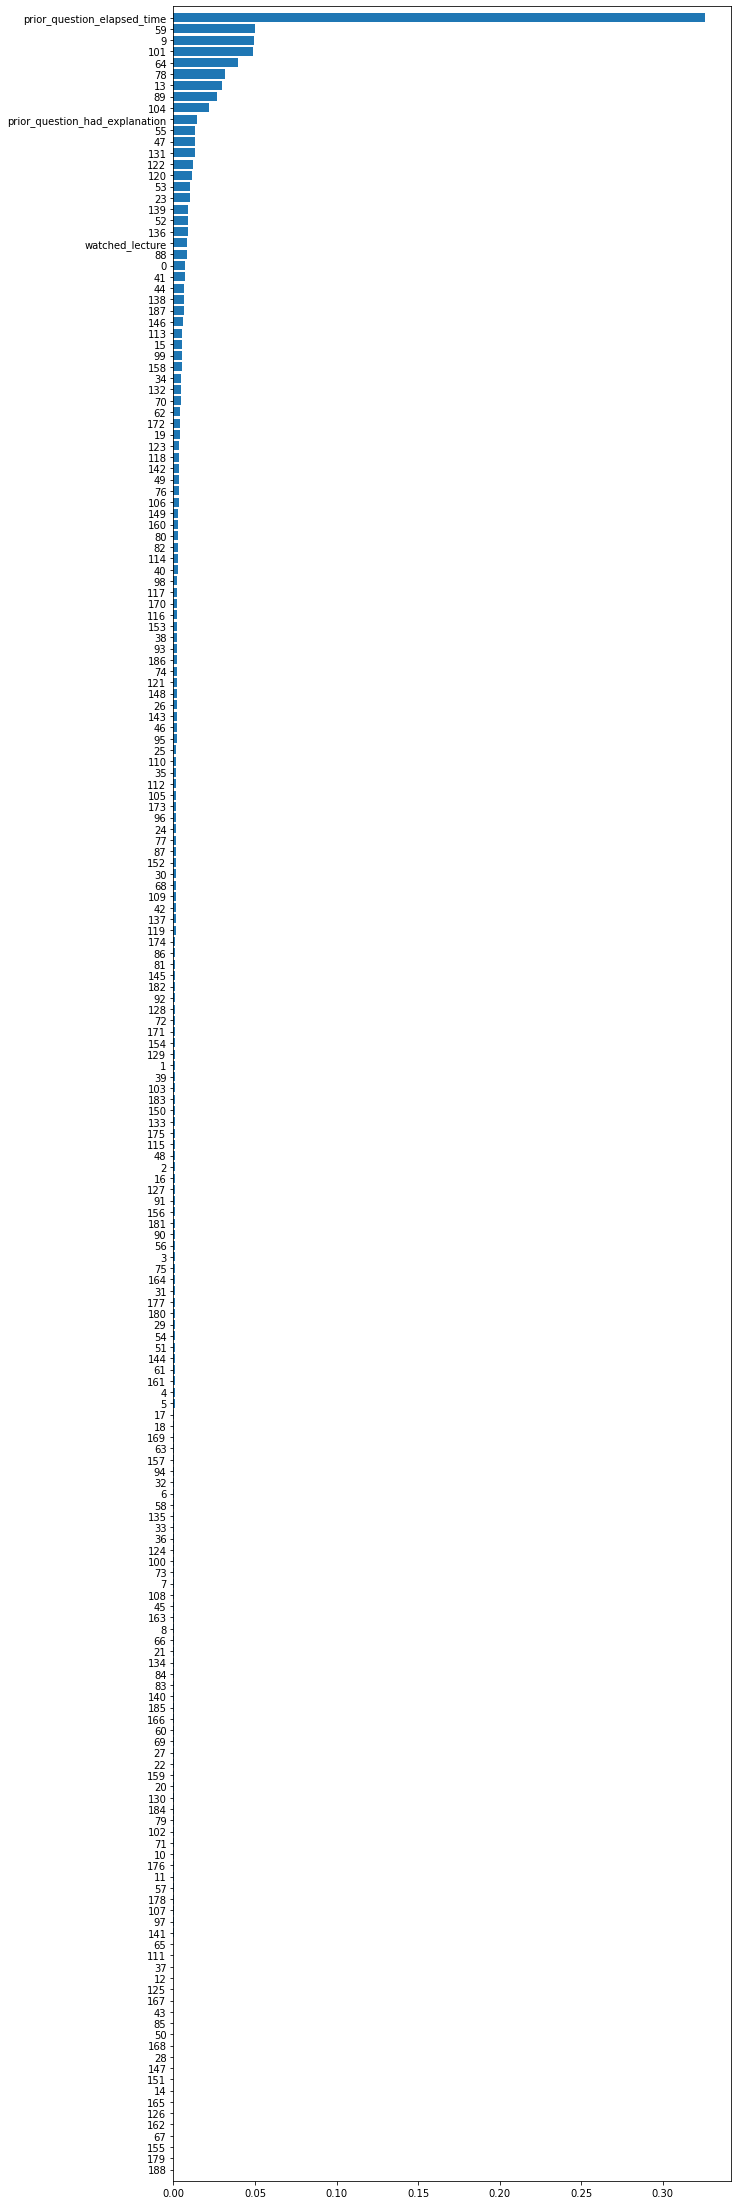

In [ ]:
# This cell shows the feature importances given by our gradient boosted classifier.

xgboost = GradientBoostingClassifier(learning_rate=.0001, max_features= 'sqrt', n_estimators=200, criterion= 'friedman_mse',max_depth=10, loss = 'exponential',min_samples_split=6, tol= 1e4, subsample=.5)
xgboost.fit(train_x, train_y)
pred = xgboost.predict(val_x)
fig,ax = plt.subplots(figsize = (10,40))
importances = xgboost.feature_importances_
idx = np.argsort(importances)
plt.barh(y = range(train_x.shape[1]),width= importances[idx])
plt.yticks( idx,column_names.to_list())
plt.ylim([-1,train_x.shape[1]])

As previously seen with PCA, we see that there are only a few features that actually have feature importance, making this dataset a great candidate for dimensionality reduction.

# Using Top Feature Importance for Dimensionality Reduction


In [ ]:
!pip install shap


In [ ]:
import shap

In [ ]:
#Enables the Javascript necessary for some of the Shapely Values methods
shap.initjs()

100%|===================| 27047/27050 [113:18<00:00]       

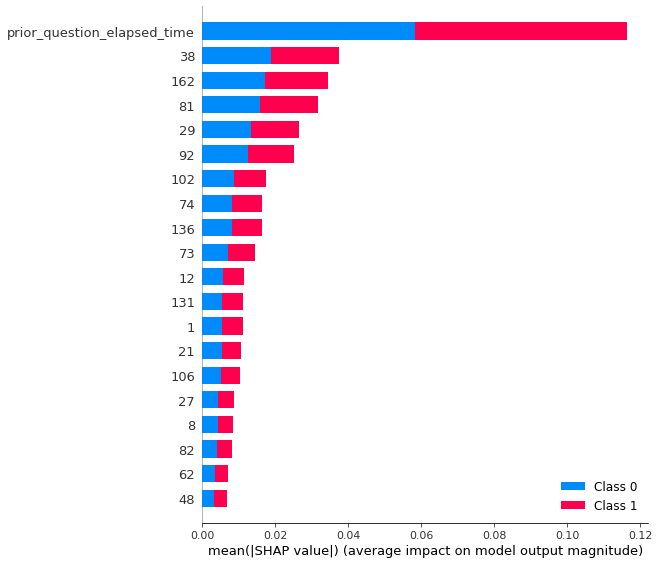

In [ ]:
# Shapely values is a model agnostic framework that finds the additive feature importance of each feature of the data using
# a game theoretic approach. Source: https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html
# We will use this framework to take the top n features ranked by this algorithm to perform dimensionality reduction.
model = RandomForestClassifier(criterion= 'gini',max_features='auto', n_jobs=-1,n_estimators=400 )
model.fit(val_x, val_y)

explainer = shap.TreeExplainer(model,val_x)
shap_values = explainer.shap_values(val_x)
shap.summary_plot(shap_values,val_x, feature_names=column_names)

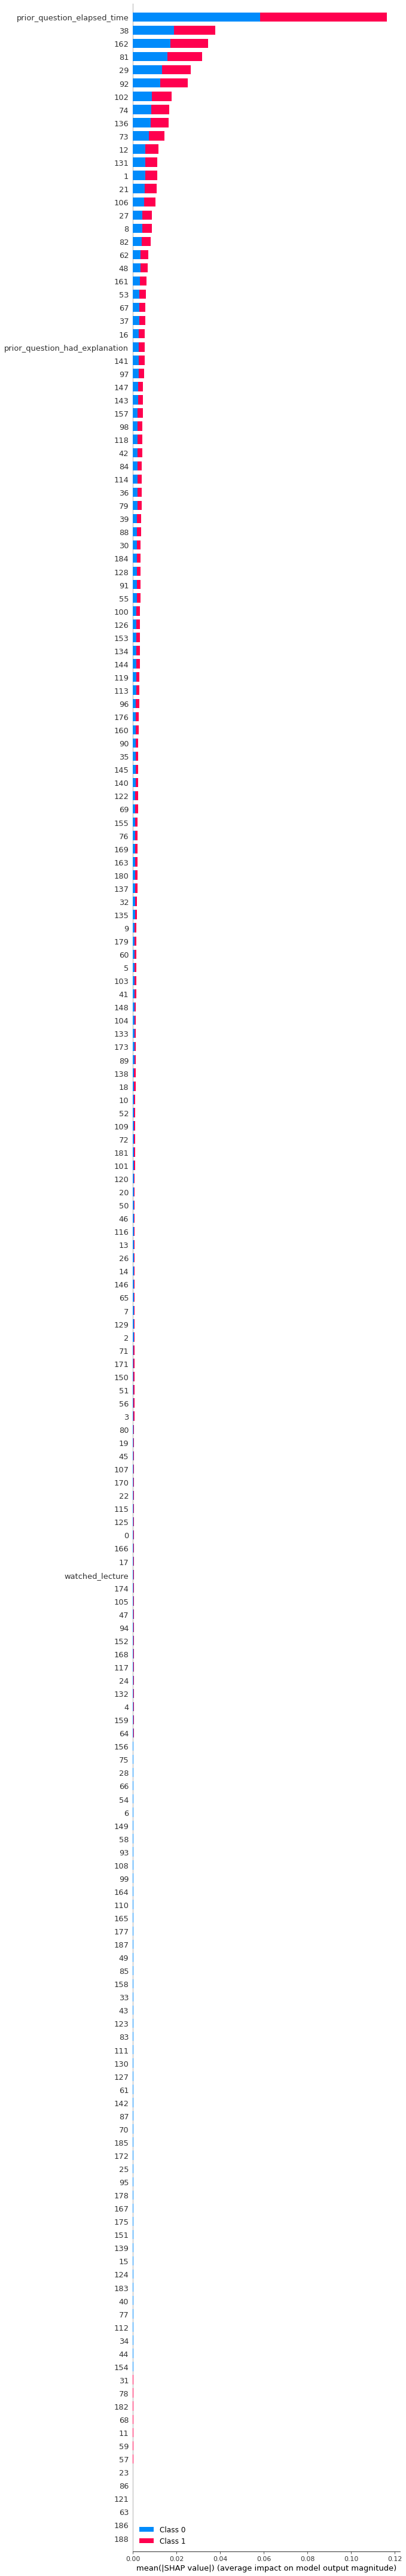

In [ ]:
shap.summary_plot(shap_values, train_x,  feature_names=column_names,plot_type="bar", max_display=192)


In [ ]:
#This saves the Shapely value calculations so they do not need to be recalculated

pd.DataFrame(np.abs(shap_values).mean(axis = 1).mean(axis=0)).to_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/shap.csv')

In [ ]:
#This reads in the Shapely values csv
shap_values = pd.read_csv('/content/drive/My Drive/w207 Kaggle Project/riiid-test-answer-prediction/shap.csv')
shap_values = shap_values.drop('Unnamed: 0', axis = 1)
shap_values

,0
0,0.058230
1,0.002651
2,0.000205
3,0.000234
4,0.005539
...,...
187,0.001764
188,0.000085
189,0.000002
190,0.000107


In [ ]:
#This validates the top n features from Shapely on our model.
num_features = train_x.shape[1]
best_score = -1
best_num = 0
idx = np.argsort(shap_values.to_numpy().flatten())
for i in range(50,num_features+1):
  t_x = train_x[:,idx[:i]]
  t_y = train_y
  v_x = val_x[:,idx[:i]]
  v_y = val_y
  model = KNeighborsClassifier(n_neighbors=4,metric='sokalsneath', n_jobs = -1)
  model.fit(t_x, t_y)
  pred = model.predict(v_x)
  score=roc_auc_score(v_y, pred)
  if score> best_score:
    best_score = score
    best_num = i
  print(i, score)
print(best_num, best_score)

188 0.5407125288609804
189 0.5392068541977617
190 0.5487522735881218
191 0.5496269894252874
192 0.5566739633018074
192 0.5566739633018074


# Holdout Dataset and Testing Dataset


In [ ]:
# This cell trains our optimal KNN model and is tested on the holdout set
model = KNeighborsClassifier(n_neighbors = 4, metric = 'sokalsneath', n_jobs = -1)
model.fit(train_x, train_y)
pred = model.predict(X_holdout)
roc_auc_score(Y_holdout, pred)

0.5473254770817036

In [ ]:
# The same model is also tested on our test set
pred = model.predict(test_x)
roc_auc_score(test_y, pred)

0.5519396694892482